[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)

# Multiple Schemas

## Review

We just covered state schema and reducers.

Typically, all graph nodes communicate with a single schema.

Also, this single schema contains the graph's input and output keys / channels.

## Goals

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

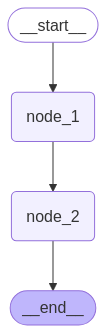

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` is only included in `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `baz` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema.

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

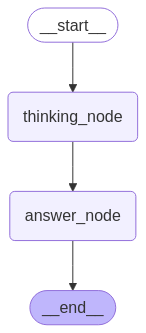

In [17]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"question":"ttt","answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
pip install pytesseract pillow transformers langgraph

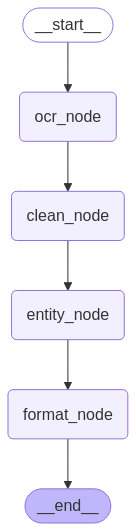

1 Node: OCR Extraction
OCR Output: Year Santa.
T have been very good this
Year and have been thinki
oF what T would like For
Christmas,
\ leao
1, leicycle
%. euRRY
Tam very excited for your
Visit and will leave out Some
Snacks foe you and your
weindeer.

love

2 Node: Text Cleaning
Cleaned Text: Year Santa. T have been very good this Year and have been thinki oF what T would like For Christmas, \ leao 1, leicycle %. euRRY Tam very excited for your Visit and will leave out Some Snacks foe you and your weindeer. love
3 Node: Entity Extraction


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


Extracted Entities: {'PER': 'Tam', 'MISC': 'Snac'}
4 Node: Formatting Result
PER: Tam
MISC: Snac

Final State: {'image_path': '/content/images.png', 'ocr_text': 'Year Santa.\nT have been very good this\nYear and have been thinki\noF what T would like For\nChristmas,\n\\ leao\n1, leicycle\n%. euRRY\nTam very excited for your\nVisit and will leave out Some\nSnacks foe you and your\nweindeer.\n\nlove\n\x0c', 'cleaned_text': 'Year Santa. T have been very good this Year and have been thinki oF what T would like For Christmas, \\ leao 1, leicycle %. euRRY Tam very excited for your Visit and will leave out Some Snacks foe you and your weindeer. love', 'entities': {'PER': 'Tam', 'MISC': 'Snac'}}


In [21]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
import pytesseract
import torch
from transformers import pipeline
from PIL import Image as PILImage  # ✅ Alias it
from IPython.display import display


# Define the processing state
class State(TypedDict):
    image_path: Annotated[str, "Path to the input image"]  # ✅ ADD THIS LINE
    ocr_text: Annotated[str, "OCR raw text"]
    cleaned_text: Annotated[str, "Cleaned text"]
    entities: Annotated[dict, "Extracted key-value pairs"]

# 1. OCR Node
def ocr_node(state):
    print("1 Node: OCR Extraction")
    image_path = state.get("image_path")
    if not image_path:
        raise ValueError("Missing 'image_path' in state.")
    text = pytesseract.image_to_string(PILImage.open(image_path))
    print("OCR Output:", text)
    return {"ocr_text": text}

# 2. Text Cleaning Node
def clean_text_node(state):
    print("2 Node: Text Cleaning")
    text = state['ocr_text']
    cleaned = ' '.join(text.split()).strip()  # Removes extra spaces and line breaks
    print("Cleaned Text:", cleaned)
    return {"cleaned_text": cleaned}

# 3. Entity Extraction Node
def entity_extraction_node(state):
    print("3 Node: Entity Extraction")
    text = state['cleaned_text']

    # Using a real model from HuggingFace for entity extraction
    ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", grouped_entities=True, device=0 if torch.cuda.is_available() else -1)
    ner_results = ner_pipeline(text)

    extracted = {}
    for entity in ner_results:
        label = entity['entity_group']
        value = entity['word']
        extracted[label] = value

    print("Extracted Entities:", extracted)
    return {"entities": extracted}

# 4. Format Output Node
def format_result_node(state):
    print("4 Node: Formatting Result")
    entities = state["entities"]
    for k, v in entities.items():
        print(f"{k}: {v}")
    return {}

# Build graph
builder = StateGraph(State)
builder.add_node("ocr_node", ocr_node)
builder.add_node("clean_node", clean_text_node)
builder.add_node("entity_node", entity_extraction_node)
builder.add_node("format_node", format_result_node)

# Connect the nodes
builder.add_edge(START, "ocr_node")
builder.add_edge("ocr_node", "clean_node")
builder.add_edge("clean_node", "entity_node")
builder.add_edge("entity_node", "format_node")
builder.add_edge("format_node", END)

# Compile and visualize
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# Run the graph with a sample image
image_path = "/content/images.png"  # Replace with your actual image
final_state = graph.invoke({"image_path": image_path})
print("\nFinal State:", final_state)


Notice that the output of invoke contains all keys in `OverallState`.

In [18]:
graph.invoke({"question":"hi" ,"answer": "bye"})

{'question': 'ttt', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

Now, let's use a specific `input` and `output` schema with our graph.

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph.

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`.

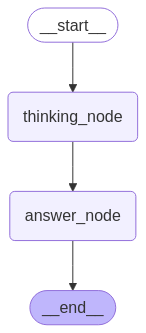

{'answer': 'bye Lance'}

In [20]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance", "notes": "... his is name is Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

We can see the `output` schema constrains the output to only the `answer` key.